In [1]:
using constants
using types
using Optim
using PyPlot
using data
include("DOSfunctions.jl")
include("userfunctions.jl")
include("propertyfuncs.jl")

electronicthermalPropsiso (generic function with 1 method)

In [3]:
#Ts=collect(300.0:10.0:800.0)
Ts=collect(200:50.0:1200)
numofn=[-0.5e20]#,-7.3e19,-2.0e19,-0.22e19]#,-0.2e20]#,-1.75e20,-3.0e19,-0.9e20]#Sample 1 -3.0e19, Sample 2 -1.25e20,
#Sample 3 -1.75e20, Sample Sb 0.75% -1.03e20, #
numofnn=[0.1e18]#,1.8e18,1.8e18,1.8e18]#,1e17]
xs=[0.2]#,0.3,0.3,0.3]#[0.287,0.3,0.262,0.332]#collect(0.0:0.01:1.0)

var0=[Ts[1],xs[1]]
Eoff=2.0
Ev(var)=Eoff
Ec(var)=Ev(var)+EgSiGe(var[1],var[2])-0.5#var[1]:T var[2]:x

effMassV(var)=-1.2*me
effMassC(var)=0.321*me#0.424*me#1.4/6^(2/3)*me

bandC=parBandTx(effMassC(var0),0.0,Ec(var0),[Ec],[effMassC],var0)
bandV=parBandTx(effMassV(var0),0.0,Ev(var0),[Ev],[effMassV],var0)
#bndstTx=BandStrucTx([bandV,bandC,bandC,bandC,bandC,bandC,bandC],var0)
bndstTx=BandStrucTx([bandC,bandC,bandC,bandC,bandC,bandC,bandV],var0)
#var array: var[1]: effMass , var[2]:T, var[3]:E, var[4]:x, var[5]:Ef, 
#var[6]:band, var[7]:NII var[8]:bndst var[9]:NNI

#md=1.4*me;
#md=6^(2/3)*
function Deftemp(band::parBandTx)
    if band==bandC
        return 9
    end
    if band==bandV        
        return 2
    end
end
ksi=21.0
tauAC(var)=tauAC_func(ClSiGe(var[4],var[2]),Deftemp(var[6]),var[2],var[1],var[3],var[6])#DefP(var[1])
tauII2(var)=tauII2_func(ksi*eps0,eps0,var[6],var[5],var[2],var[7],var[1],var[3],var[8])
tauNI(var)=tauNI_func(ksi*eps0,var[1],var[9])
vartau0=[bandC.effMass,Ts[1],Ec(var0),xs[1],Ec(var0),bandC,numofn[1]*1e6,bndstTx,numofnn[1]*1e6]
#vartau0=[bandC.effMass,Ts[1],1.0,xs[1],1.5,bandC,numofn[1]*1e6,bndstTx,numofnn[1]*1e6]
tauTOTTx=tau_electron_B([tauAC,tauII2,tauNI],vartau0)#tauNI,,tauII2
xmax=3.0
#T_EF_Dict=Dict()
#println("-3")

In [4]:
@time (Efs,sigmas,seebecks,kes,kees,kehs,kbis)=electronicPropsiso(bndstTx,xs,Ts,numofn,tauTOTTx,xmax)
xmax=3.0

  7.574849 seconds (57.57 M allocations: 9.462 GB, 7.69% gc time)


In [5]:
Efsr=Array{Float64,3}(length(Ts),length(numofn),length(xs))
for (i,iT) in enumerate(Ts)
    for (k,kx) in enumerate(xs) 
        for (j,jn) in enumerate(numofn)
            Efsr[i,j,k]=Efs[i,j,k]-Ec([iT,kx])
        end
    end
end
#println("-2")
#for (Ti,Tx) in enumerate(Ts)
#    T_EF_Dict[Tx]=(Efsr[Ti])    
#end
T_EF_Dict_Array=Array{Dict{Float64,Float64},2}(length(numofn),length(xs))
Dict_temp=Dict()
Efsr=Array{Float64,3}(length(Ts),length(numofn),length(xs))
for (j,jn) in enumerate(numofn)
    for (k,kx) in enumerate(xs) 
        for (i,iT) in enumerate(Ts)
            Efsr[i,j,k]=Efs[i,j,k]-Ec([iT,kx])
            Dict_temp[iT]=Efsr[i,j,k]
            T_EF_Dict_Array[j,k]=Dict_temp 
        end
    end
end

In [6]:
#println("-1")
#############Lattice Thermal Conductivity Parameters###############
thetaSiL=586.0 # K 
thetaSiT=240.0 # K
vSiL=8430.0    # m/s
vSiT=5840.0    # m/s
vGeL=4920.0    # m/s
vGeT=3540.0    # m/s
gammaL=0.9
gammaT=0.6
MSi=4.6637e-26 # kg
MGe=1.206e-25  # kg
VSi=2.0024e-29
#println("0")
Eh=3.8
Eep=3*q
xsp=xs[1]
Tp=300.0
p=1.0
D=20e-9
NP=0.0
a=2.65#0.488
alpha=0.5 #specularity factor
d=97.0e-9#

#println("1")


md=6^(2/3)*bandC.effMass


#vartauPH0=[[0.02],Ts[1],gammaL,gammaT,xsp,thetaCLx,thetaCTx,thetaCTx,MSi,MGe,VSi,a,T_EF_Dict,0.0]
vartauPH0=[ [0.02],  Ts[1],   gammaL,  gammaT, xsp,
    thetaSiL, thetaSiT, thetaSiT, MSi,   MGe, 
    VSi, a, T_EF_Dict_Array, Eep, alpha, 
    d, thetaSiL, thetaSiT, vSiL, vSiT, 
    vGeL, vGeT, p, NP,Tsindex=1,
    numberofnindex=1,xsindex=1]
thetaCLx=thetaCL(vartauPH0[12],vartauPH0[5],vartauPH0[17],vartauPH0[19],vartauPH0[11])
thetaCTx=thetaCT(vartauPH0[12],vartauPH0[5],vartauPH0[18],vartauPH0[19],vartauPH0[11])
#println("2")
tauPHNLf(var)=tauPH_NL(var[3],VSiGe(var[5]),var[1],var[2],MSiGe(var[5]),vSiGeL_PH(var[5]))
tauPHNTf(var)=tauPH_NT(var[4],VSiGe(var[5]),var[1],var[2],MSiGe(var[5]),vSiGeT_PH(var[5]))


tauPHULf(var)=tauPH_U(var[3],var[1],var[2],MSiGe(var[5]),vSiGeL_PH(var[5]),var[17])
tauPHUTf(var)=tauPH_U(var[4],var[1],var[2],MSiGe(var[5]),vSiGeT_PH(var[5]),var[18])

tauPHALLLf(var)=tauPH_ALL(var[9],var[10],var[5],VSiGe(var[5]),var[1],var[2],MSiGe(var[5]),vSiGeL_PH(var[5]))
tauPHALLTf(var)=tauPH_ALL(var[9],var[10],var[5],VSiGe(var[5]),var[1],var[2],MSiGe(var[5]),vSiGeT_PH(var[5]))

tauPHeLf(var)=tauPH_e(var[14],md,MSiGe(var[5])/VSiGe(var[5]),(var[13][var[26],var[27]])[var[2]],var[1],var[2],vSiGeL_PH(var[5]))
tauPHeTf(var)=tauPH_e(var[14],md,MSiGe(var[5])/VSiGe(var[5]),(var[13][var[26],var[27]])[var[2]],var[1],var[2],vSiGeT_PH(var[5]))

tauPHBLf(var)=tauPH_B(vSiGeL_PH(var[5]),var[14],var[15])
tauPHBTf(var)=tauPH_B(vSiGeT_PH(var[5]),var[14],var[15])
#println("3")
tauPHTOTL=tau_phonon_B([tauPHNLf,tauPHULf,tauPHALLLf,tauPHeLf],vartauPH0)#,tauPH_eLf ,tauPHALLLf ,tauPHBLf
tauPHNL=tau_phonon_B([tauPHNLf],vartauPH0)
tauPHRL=tau_phonon_B([tauPHULf,tauPHALLLf,tauPHeLf],vartauPH0) #,tauPHALLLf,tauPH_eLf] ,tauPHBLf


tauPHTOTTx=tau_phonon_B([tauPHNTf,tauPHUTf,tauPHALLTf,tauPHeTf],vartauPH0) #tauPHALLTf,tauPH_eTf ,tauPHBTf
tauPHNTx=tau_phonon_B([tauPHNTf],vartauPH0)
tauPHRTx=tau_phonon_B([tauPHUTf,tauPHALLTf,tauPHeTf],vartauPH0) #,tauPHALLTf,tauPH_eTf ,tauPHBTf


tauPHTOTTy=tau_phonon_B([tauPHNTf,tauPHUTf,tauPHALLTf,tauPHeTf],vartauPH0) #,tauPHALLTf,tauPH_eTf tauPHBTf
tauPHNTy=tau_phonon_B([tauPHNTf],vartauPH0)
tauPHRTy=tau_phonon_B([tauPHUTf,tauPHALLTf,tauPHeTf],vartauPH0) #,tauPHALLTf,tauPH_eTf ,tauPHBTf
#println("4")

tauPHL=[tauPHTOTL,tauPHNL,tauPHRL]
tauPHTx=[tauPHTOTTx,tauPHNTx,tauPHRTx]
xmax=1.0

1.0

In [7]:
@time klattice=thermalPropsiso(tauPHL,tauPHTx,tauPHTx,[vSiGeL_PH(xsp),vSiGeT_PH(xsp),vSiGeT_PH(xsp)])
xmax=3.0

  0.535762 seconds (680.06 k allocations: 229.716 MB, 3.47% gc time)


3.0

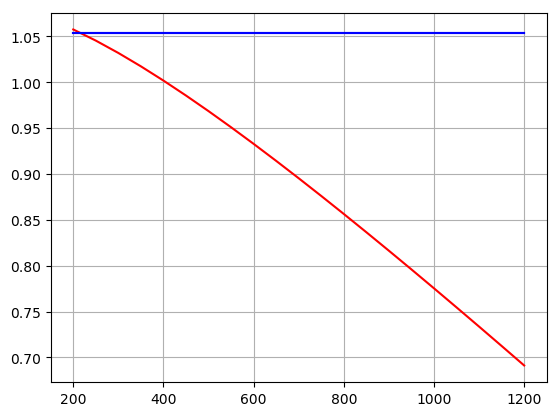

21-element Array{Array{Float64,1},1}:
 [1.05321,1.0531]
 [1.05321,1.0531]
 [1.05321,1.0531]
 [1.05321,1.0531]
 [1.05321,1.0531]
 [1.05321,1.0531]
 [1.05321,1.0531]
 [1.05321,1.0531]
 [1.05321,1.0531]
 [1.05321,1.0531]
 [1.05321,1.0531]
 [1.05321,1.0531]
 [1.05321,1.0531]
 [1.05321,1.0531]
 [1.05321,1.0531]
 [1.05321,1.0531]
 [1.05321,1.0531]
 [1.05321,1.0531]
 [1.05321,1.0531]
 [1.05321,1.0531]
 [1.05321,1.0531]

In [8]:
Ec_Vin(y,x)=0.8941+0.0421(1-y)+0.1961(1-y)^2-[0.00037y
    +0.00023(1-y)]
Ec_Vin_A=map(x->Ec_Vin(0.2,x),Ts)
Ec_A=map(x->Ec([x,xs[1]])-Eoff+0.5,Ts)
figure()
plot(Ts,Ec_A,linestyle="-",color="r")
plot(Ts,Ec_Vin_A,linestyle="-",color="b")
grid()
Ec_Vin_A

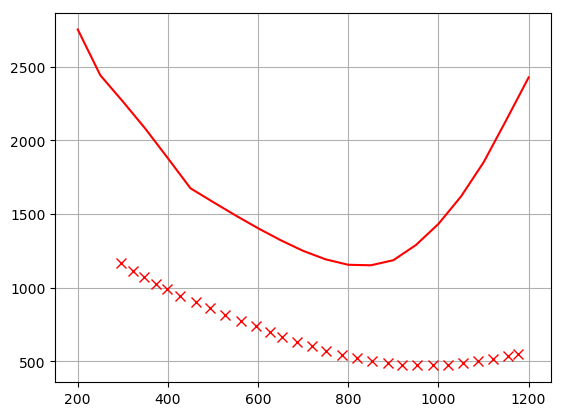

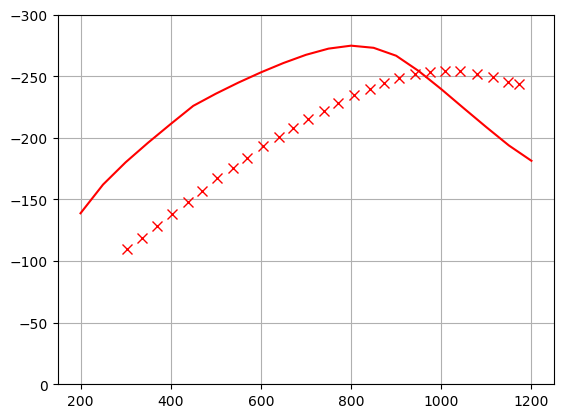

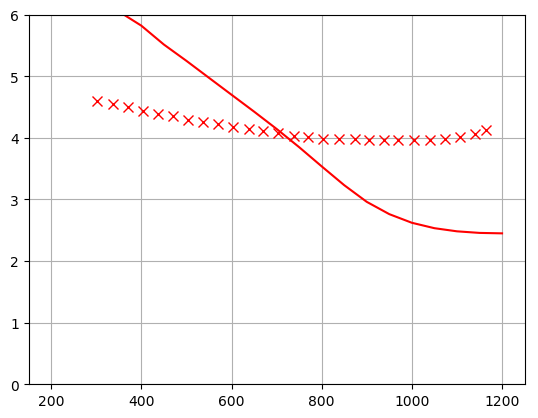

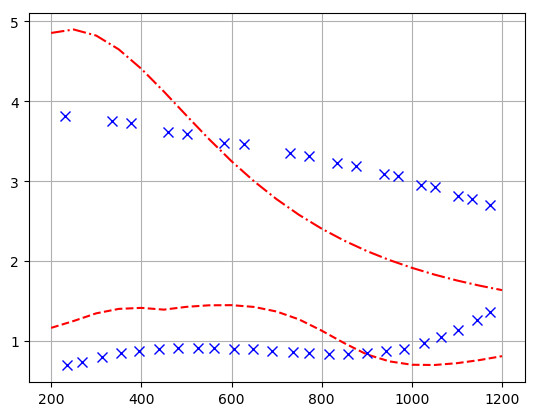

In [9]:
SiGe_Min_02Ge_Bulk_EC_T=[296.9121959634,322.7613028683,347.0898740728,372.9389809776,397.2675521822,425.9887820764,
461.1300515941,493.9060433558,526.3441382951,561.8233046351,594.2613995745,626.6994945139,653.5864273729,686.5072320584,
718.9453269978,751.3834219372,786.5246914548,819.3006832165,852.8200479872,887.2179444958,919.4629555368,953.1754042059,
987.5395110324,1020.3492924763,1053.5307604247,1087.8948672511,1120.1736679743,1154.4943309235,1175.7818307275]
SiGe_Min_02Ge_Bulk_EC_E=[1167.930411377,1116.7383039593,1071.3386917644,1027.6439779418,988.9696700287,944.0456471767,
901.9915076103,861.5799265483,816.3949815973,775.6185828417,738.3730639056,697.2842559431,666.4569029671,633.8866857923,
604.0748969464,570.7738062214,546.056187187,524.4590229963,501.6814306572,488.3087278539,478.6906927012,473.6275774098,
472.9036344822,478.6291805288,487.5249938199,502.4460185567,516.0951929325,536.7208646439,548.5699691767]
SiGe_Min_02Ge_Bulk_SC_T=[302.9412892539,337.3790597606,369.7270540544,403.5117694946,437.9495400012,469.2635304398,
503.6759043605,538.5200202418,569.8340106804,604.9574890069,639.0905004825,670.404490921,704.8168648418,740.3720851289,
771.6606789815,806.0984494881,840.9425653695,873.4501953463,905.957825323,941.5130456101,974.0206755869,1007.2394099694,
    1041.067662414,1079.6704730114,1114.5145888928,1147.7333232753,1172.1140457579]
SiGe_Min_02Ge_Bulk_SC_S=[-109.5868470637,-118.5318420818,-128.1003808452,-138.3231695007,-148.2478622404,-157.2029975781,
-167.0369673909,-175.7045019946,-183.8527157592,-193.4378268414,-200.3701424254,-207.7636471893,-215.4147095572,
-222.2176436451,-228.6825982854,-234.4948389611,-240.0376356981,-244.9111754166,-248.6012301612,-251.6089958573,
-253.3940828099,-254.2149460504,-254.3869490905,-251.7782657304,-249.332855334,-245.4640802559,-244.1194856901]
SiGe_Min_02Ge_Bulk_KC_T=[302.488999012,336.5489986984,370.7610519548,402.8443552308,437.2422517394,471.1164081735,
503.1997114495,537.5976079581,569.8426189991,603.5550676682,637.9191744946,670.1979752178,703.910423887,738.2745307134,
770.5533314365,803.860303919,839.3394702589,872.9179669735,905.2293506045,938.9852431508,970.2322517917,1004.5710163564,
    1040.0501826964,1072.4882776358,1105.635955902,1140.4055389151,1165.2409553531]
SiGe_Min_02Ge_Bulk_KC_K=[4.59766179,4.555497223,4.4997475429,4.4334947973,4.3848479032,4.347668876,4.291323817,
    4.2596585186,4.2239187086,4.179492164,4.149048596,4.1071569149,4.0722114102,4.0383546678,4.0212762224,3.9883139763,
3.9763778937,3.9782794534,3.9693586568,3.9637333075,3.9676809691,3.9646374032,3.9676602945,3.9841429948,4.0180849145,
    4.0660127593,4.1252046428]
SiGe_Min_02Ge_Bulk_KlC_T=[231.6320353788,335.0284629981,377.6034626061,459.7123904214,502.2873900293,584.3963178447,
626.9713174526,730.3677450719,772.9427446799,833.7641726912,876.3391722992,937.1606003105,969.0918500165,1019.2695281258,
    1051.2007778318,1101.3784559412,1133.3097056471,1172.8436338545]
SiGe_Min_02Ge_Bulk_KlC_Kl=[3.8204135885,3.7570923668,3.7340266957,3.6197434658,3.585315096,3.4823945649,3.4593288939,
    3.3505568767,3.3161285068,3.2304221607,3.1959937909,3.0932433965,3.0645814443,2.9562347689,2.9275728167,
2.8192261413,2.7792014903,2.6993466303]

SiGe_Min_02Ge_Bulk_KeC_T=[234.1662615459,268.631737419,313.7409631941,354.7954271018,395.8498910095,438.4248906174,
480.9998902254,526.1091160004,560.5745918735,605.6838176486,648.2588172566,690.8338168645,735.9430426396,
772.9427446799,815.5177442878,858.0927438957,900.6677435037,941.7222074114,982.776671319,1027.8858970941,
    1064.8855991344,1101.8853011746,1143.9534555491,1172.8436338545]

SiGe_Min_02Ge_Bulk_KeC_Ke=[0.6956511512,0.7408264872,0.8029608032,0.8480834778,0.8761621042,0.8985472286,0.9152510035,
0.9129966927,0.9127212333,0.9028917899,0.8968701672,0.8794858455,0.8620812696,0.850422857,0.8444012342,0.8383796115,
0.849402037,0.871799314,0.9055592898,0.9809500877,1.0526181334,1.1356488779,1.2678774753,1.3585481663]


figure()
plot(Ts,sigmas[:,1,1]/100,linestyle="-",color="r")
plot(SiGe_Min_02Ge_Bulk_EC_T,SiGe_Min_02Ge_Bulk_EC_E, linestyle="None",marker="x",markersize=7,color="r")
grid()

figure()
plot(Ts,seebecks[:,1,1]*1e6,linestyle="-",color="r")
plot(SiGe_Min_02Ge_Bulk_SC_T,SiGe_Min_02Ge_Bulk_SC_S, linestyle="None",marker="x",markersize=7,color="r")
ylim(0,-300)
grid()

figure()
plot(Ts,klattice[:,1,1]+kes[:,1,1]+kbis[:,1,1],linestyle="-",color="r")
plot(SiGe_Min_02Ge_Bulk_KC_T,SiGe_Min_02Ge_Bulk_KC_K, linestyle="None",marker="x",markersize=7,color="r")
ylim(0,6)
grid()
figure()
plot(Ts,klattice[:,1,1],linestyle="-.",color="r")
plot(Ts,kbis[:,1,1]+kes[:,1,1],linestyle="--",color="r")
#plot(Ts,kbis[:,1,1],linestyle=":",color="r")
plot(SiGe_Min_02Ge_Bulk_KlC_T,SiGe_Min_02Ge_Bulk_KlC_Kl, linestyle="None",marker="x",markersize=7,color="b")
plot(SiGe_Min_02Ge_Bulk_KeC_T,SiGe_Min_02Ge_Bulk_KeC_Ke, linestyle="None",marker="x",markersize=7,color="b")
grid()